In [1]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

In [2]:
# define the model parameters
num_validation = 5000
num_feature = 2000
batch_size = 20
epoch = 300
lr = 0.1
hidden_unit = 200

In [3]:
def read_data(dataset, category):
    '''
    import the data from the directory
    argument:
    dataset: "train" or "test"
    category: "pos" or "neg"
    return: 
    result_list: a list of strings
    '''
    result_list = []
    path = str(dataset)+'/'+str(category)
    entries = os.listdir(path)
    for txt in entries:
        #print(txt)
        with open(os.path.join(path, txt), encoding='utf-8') as f:
            text = f.readline().strip().lower()
            result_list.append(text)
    #result_list = np.array(result_list)
    return result_list

def data_preprocessing(num_feature,num_validation,filename):
    '''
    Data preprocessing 
    
    Argument:
    filename(str): location and name of the file to store the training/val/test sets
    
    Return:
    store the training data, validation data, test data
    '''
    # read data
    train_pos = read_data('train', 'pos')
    train_neg = read_data('train', 'neg')
    test_neg = read_data('test', 'neg')
    test_pos = read_data('test', 'pos')
    
    # shuffle the training data
    np.random.seed(314)
    np.random.shuffle(train_pos)
    np.random.seed(314)
    np.random.shuffle(train_neg)
    
    # define validation data
    #num_validation
    #print((len(train_pos) - num_validation//2))
    # take 5000 samples as validation from the shuffled training dataset
    val_pos = train_pos[(len(train_pos) - num_validation//2):len(train_pos)]
    train_pos_final = train_pos[0:(len(train_pos) - num_validation//2)]
    val_neg = train_neg[(len(train_neg) - num_validation//2):len(train_neg)]
    train_neg_final = train_neg[0:(len(train_neg) - num_validation//2)]
    
    # combine pos and neg 
    X_train = train_pos_final + train_neg_final
    y_train = [1] * len(train_pos_final) + [0] * len(train_neg_final)
    y_train = np.array([y_train]).T
    X_val = val_pos + val_neg
    y_val = [1] * len(val_pos) + [0] * len(val_neg)
    y_val = np.array([y_val]).T
    X_test = test_pos + test_neg
    y_test = [1] * len(test_pos) + [0] * len(test_neg)
    y_test = np.array([y_test]).T
    
    # shuffle the training data
    np.random.seed(314)
    np.random.shuffle(X_train)
    np.random.seed(314)
    np.random.shuffle(y_train)
    
    # generate word2id dictionary
    vocab = dict()
    for sentence in X_train:
        for w in sentence.split():
            if w in vocab:
                vocab[w] += 1
            else:
                vocab[w] = 1
    vocab = sorted(vocab.items(), key=lambda x: x[1], reverse=True)
    
    word2id = {}
    i = 0
    for tp in vocab:
        word2id[tp[0]] = i
        i+= 1
        if i == num_feature:
            break
    
    # define feature matrix
    X_train_matrix = []
    for sample in X_train: 
        repr_sample = np.zeros(num_feature,dtype=int)
        tokens = set(sample.split())
        for tk in tokens:
            if tk in word2id:
                repr_sample[word2id[tk]] = 1
        X_train_matrix.append(repr_sample)
    X_train_matrix = np.array(X_train_matrix) 
    
    X_val_matrix = []
    for sample in X_val: 
        repr_sample = np.zeros(num_feature,dtype=int)
        tokens = set(sample.split())
        for tk in tokens:
            if tk in word2id:
                repr_sample[word2id[tk]] = 1
        X_val_matrix.append(repr_sample)
    X_val_matrix = np.array(X_val_matrix)
    
    X_test_matrix = []
    for sample in X_test: 
        repr_sample = np.zeros(num_feature,dtype=int)
        tokens = set(sample.split())
        for tk in tokens:
            if tk in word2id:
                repr_sample[word2id[tk]] = 1
        X_test_matrix.append(repr_sample)
    X_test_matrix = np.array(X_test_matrix)
    
    # store data
    pickle.dump((X_train_matrix, y_train, X_val_matrix, y_val, X_test_matrix, y_test), open(filename, "wb"))


In [11]:
def sigmoid(x):
    '''
    Compute the sigmoid function for x
    
    Argument: 
    x: a numpy array
    
    Return: 
    sigmoid of x
    '''
    return 1/(1+np.exp(-x))


def sigmoid_derivative(x):
    '''
    Compute the derivative of sigmoid function for x
    
    Argument: 
    x: a numpy array
    
    Return: 
    the derivative of sigmoid of x
    '''
    return sigmoid(x)*(1-sigmoid(x))


def classify(predictions):
    '''
    Compute the binary class label 
    
    Argument:
    predictions: a numpy array of probablities
    
    Return:
    the binary class label, 0 or 1
    '''
    return [1 if p>0.5 else 0 for p in predictions]


def accuracy(predicted_labels, actual_labels):
    '''
    Compute the accuracy of prediction
    
    Argument:
    predicted_labels: the predicted labels
    actual_labels: the true labels 
    
    Return:
    the accuracy
    '''
    agreement = 0
    for i in range(len(predicted_labels)):
        if predicted_labels[i] == actual_labels[i]:
            agreement+=1
    return agreement/len(predicted_labels)


def cross_entropy_loss(x,y,w_hidden,b_hidden, w_out, b_out):
    '''
    Compute the loss function
    
    Argument:
    x: feature matrix
    y: the true labels
    w_hidden: weights for hidden layer 
    b_hidden: bias for hidden layer
    w_out: weights for output layer
    b_out: bias for output layer
    
    Return:
    the loss
    '''
    #predicted_prob = sigmoid(np.dot(x,w)+b)
    #b_hidden_for_calculation = np.repeat(b_hidden.T, x.shape[0], axis = 0)
    #print("x_dimension", x.shape)
    #print("b_hidden_for_calculation dim",b_hidden_for_calculation.shape)
    x_hidden = prediction(x, w_hidden, b_hidden)
    # output layer
    y_hat = prediction(x_hidden, w_out, b_out)
    return np.mean(-(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)))


def prediction(x, w, b):
    '''
    Compute the predicted probability
    
    Argument:
    x: feature matrix
    w: weights
    b: bias
    
    Return:
    predicted probablity 
    '''
    b_for_calculation = np.repeat(b.T, x.shape[0], axis = 0)
    return sigmoid(np.dot(x,w)+b_for_calculation)


def one_hidden_NN_with_validation(x_train,y_train,x_val, y_val,hidden_unit, batch_size,epoch,learning_rate):
    '''
    Train the one hidden NN model with hold-out validation
    
    Argument:
    x_train: feature matrix for training dataset
    y_train: true labels for training dataset
    x_val: feature matrix for validation dataset
    y_val: true labels for validation dataset
    hidden_unit: the number of units for hidden layer
    batch_size: the batch size for gradient decent
    epoch: the iteration number
    learning_rate: the decending rate for gradient decent
    
    Return:
    val_acc_list: a numpy array for validation set accuracy, dim: N_epoch * 1
    train_acc_list: a numpy array for training set accuracy, dim: N_epoch * 1
    best_w_hidden: the optimized weights for hidden layer, dim: num_feature * hidden_unit
    best_b_hidden: the optimized bias for hidden layer, dim: hidden_unit * 1
    best_w_out: the optimized weights for output layer, dim: hidden_unit * 1
    best_b_out: the optimized bias for output layer, dim: 1 * 1
    '''
    val_acc_list = []
    train_acc_list = []
    w_hidden_list = []
    b_hidden_list = []
    w_output_list = []
    b_output_list = []
    
    #initialize_para
    w_out = np.array([np.random.uniform(-0.5,0.5,hidden_unit)]).T # hidden_unit * 1
    b_out = np.array([np.random.uniform(-0.5,0.5,1)]) # 1 * 1
    w_hidden = np.array([np.random.uniform(-0.5,0.5,x_train.shape[1]*hidden_unit)]).reshape([x_train.shape[1],
                                                                                             hidden_unit]) # num_feature*hidden_unit
    b_hidden = np.array([np.random.uniform(-0.5,0.5,hidden_unit)]).T # hidden_unit * 1
    #print("b_hidden dim", b_hidden.shape)
    
    for i in range(epoch):
        print("epoch",i)
        np.random.seed(31)
        np.random.shuffle(x_train)
        np.random.seed(31)
        np.random.shuffle(y_train)
        for j in range(x_train.shape[0]//batch_size):
            
            # define batch data
            x_batch = x_train[(batch_size*j):(batch_size*(j+1))]
            y_batch = y_train[(batch_size*j):(batch_size*(j+1))]
            
            # feed_forward
            # hidden layer
            x_hidden = prediction(x_batch, w_hidden, b_hidden)
            # output layer
            y_hat = prediction(x_hidden, w_out, b_out)
            
            # back probagation
            dw_out = np.dot(x_hidden.T,(y_hat - y_batch))/batch_size
            db_out = np.mean(y_hat - y_batch)
            dw_hidden = np.dot(x_batch.T, np.dot((y_hat - y_batch),w_out.T)*sigmoid_derivative(x_hidden))
            #print("tttt",((y_hat - y_batch)*sigmoid_derivative(x_hidden)).T.shape)
            db_hidden = np.mean(((y_hat - y_batch)*sigmoid_derivative(x_hidden)).T,axis = 1).reshape(200,1)
            #print("db_hidden_dimension", db_hidden.shape)
            #print("vvvv",(learning_rate*db_hidden).shape)
            
            # update parameters
            w_out -= learning_rate*dw_out
            b_out -= learning_rate*db_out
            w_hidden -= learning_rate*dw_hidden
            b_hidden -= learning_rate*db_hidden
            
            
        # validation
        loss = cross_entropy_loss(x_train,y_train,w_hidden,b_hidden, w_out, b_out)
        
        print('train loss',loss)        
        loss = cross_entropy_loss(x_val,y_val,w_hidden,b_hidden, w_out, b_out)
        print('val loss',loss)        
        
        #b_hidden_for_calculation = np.repeat(b_hidden.T, x_train.shape[0], axis = 0)
        train_accuracy = accuracy(classify(prediction(prediction(x_train, w_hidden, b_hidden), w_out, b_out)), y_train)
        print('train acc',train_accuracy)
        #b_hidden_for_calculation = np.repeat(b_hidden.T, x_val.shape[0], axis = 0)
        val_accuracy = accuracy(classify(prediction(prediction(x_val, w_hidden, b_hidden), w_out, b_out)), y_val)
        print('val acc',val_accuracy)
        
        # store the parameters after each epoch
        train_acc_list.append(train_accuracy)
        val_acc_list.append(val_accuracy)
        w_hidden_list.append(w_hidden)
        b_hidden_list.append(b_hidden)
        w_output_list.append(w_out)
        b_output_list.append(b_out)
        
    # find the optimized paramters according to validation accuracy
    best_model_idx = np.argmax(val_acc_list)
    #print("best_model_idx",best_model_idx)
    best_w_hidden = w_hidden_list[best_model_idx]
    best_b_hidden = b_hidden_list[best_model_idx]
    best_w_out = w_output_list[best_model_idx]
    best_b_out = b_output_list[best_model_idx]
    
    return val_acc_list, train_acc_list, best_w_hidden, best_b_hidden, best_w_out, best_b_out

def test_pred(x_test,y_test,w_hidden,b_hidden,w_out,b_out):
    '''
    Compute the test accuracy
    argument:
    x_test: feature matrix
    y_test: true labels 
    w_hidden: weights for hidden layer
    b_hidden: bias for hidden layer
    w_out: weights for output layer
    b_out: bias for output layer
    
    Return:
    test_accuracy: the accuracy for test dataset
    '''
    #test_loss =  cross_entropy_loss(x_test, y_test, w, b)
    #b_hidden_for_calculation = np.repeat(b_hidden.T, x_test.shape[0], axis = 0)
    test_accuracy = accuracy(classify(prediction(prediction(x_test, w_hidden, b_hidden), w_out, b_out)), y_test)
    return test_accuracy
            

In [5]:
# data
data_preprocessing(num_feature,num_validation,"data.pkl")
X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(open("data.pkl", "rb"))

In [12]:
# main 
val_acc_list, train_acc_list, best_w_hidden, best_b_hidden, best_w_out, best_b_out = one_hidden_NN_with_validation(X_train,
                                                                                                                   y_train,
                                                                                                                   X_val, 
                                                                                                                   y_val,
                                                                                                                   hidden_unit, 
                                                                                                                   batch_size,
                                                                                                                   epoch,
                                                                                                                   lr)
test_accuracy = test_pred(X_test,y_test,best_w_hidden,best_b_hidden,best_w_out,best_b_out)

epoch 0
train loss 0.3663531703694072
val loss 0.3957893147136674
train acc 0.83445
val acc 0.8248
epoch 1
train loss 0.3747084603400629
val loss 0.41234148493815576
train acc 0.83005
val acc 0.8212
epoch 2
train loss 0.3074780533661327
val loss 0.3459037774326367
train acc 0.87265
val acc 0.8514
epoch 3
train loss 0.3123803243683226
val loss 0.3541253511053411
train acc 0.86815
val acc 0.848
epoch 4
train loss 0.29878177471835504
val loss 0.3462728365392186
train acc 0.87785
val acc 0.849
epoch 5
train loss 0.29568022270714117
val loss 0.3446732234097217
train acc 0.88075
val acc 0.851
epoch 6
train loss 0.29894296077236665
val loss 0.34758219961988024
train acc 0.87815
val acc 0.8472
epoch 7
train loss 0.29770609086252015
val loss 0.34543791046293265
train acc 0.88
val acc 0.8494
epoch 8
train loss 0.29664938952274117
val loss 0.3452968876706605
train acc 0.88235
val acc 0.8524
epoch 9
train loss 0.30335117464329525
val loss 0.3530101973907184
train acc 0.8782
val acc 0.8506
epoch 10

train loss 0.27738370982169747
val loss 0.3610690215864254
train acc 0.88765
val acc 0.8492
epoch 83
train loss 0.27070001466906385
val loss 0.36357775322019975
train acc 0.8922
val acc 0.8528
epoch 84
train loss 0.2724594797078456
val loss 0.36761898522759284
train acc 0.8908
val acc 0.85
epoch 85
train loss 0.28071270761305345
val loss 0.3632508027584876
train acc 0.8844
val acc 0.8474
epoch 86
train loss 0.2733362782418198
val loss 0.3742380835643056
train acc 0.89135
val acc 0.8532
epoch 87
train loss 0.27498791539913525
val loss 0.3627715623237134
train acc 0.8879
val acc 0.8484
epoch 88
train loss 0.2754609057654117
val loss 0.36370192360629494
train acc 0.8877
val acc 0.85
epoch 89
train loss 0.26745413406008767
val loss 0.3682364280416877
train acc 0.8923
val acc 0.8514
epoch 90
train loss 0.27640331546787644
val loss 0.364067041057005
train acc 0.88645
val acc 0.8526
epoch 91
train loss 0.2653574373532032
val loss 0.361174943569337
train acc 0.8928
val acc 0.8528
epoch 92
trai

train acc 0.91215
val acc 0.8432
epoch 164
train loss 0.21673464817005453
val loss 0.39894610490287324
train acc 0.91115
val acc 0.849
epoch 165
train loss 0.21050724961006084
val loss 0.39472018981811463
train acc 0.915
val acc 0.8456
epoch 166
train loss 0.22559620437471894
val loss 0.4025973227420259
train acc 0.9065
val acc 0.8486
epoch 167
train loss 0.23372866094875552
val loss 0.40121501774962237
train acc 0.9042
val acc 0.8494
epoch 168
train loss 0.23723084975917996
val loss 0.3997238144849906
train acc 0.9036
val acc 0.846
epoch 169
train loss 0.20971249452132434
val loss 0.40100195543556305
train acc 0.9136
val acc 0.8428
epoch 170
train loss 0.21242102394489093
val loss 0.40190682076866235
train acc 0.9113
val acc 0.8452
epoch 171
train loss 0.20808616339357633
val loss 0.3940317446633695
train acc 0.9142
val acc 0.845
epoch 172
train loss 0.21897924403734023
val loss 0.3976424320600884
train acc 0.91025
val acc 0.8474
epoch 173
train loss 0.21337130633614274
val loss 0.404

train acc 0.912
val acc 0.8422
epoch 245
train loss 0.20938814761871472
val loss 0.4060228140664155
train acc 0.9222
val acc 0.839
epoch 246
train loss 0.21046117826672675
val loss 0.4098381570606245
train acc 0.91945
val acc 0.8398
epoch 247
train loss 0.2069952621240976
val loss 0.41031711153084705
train acc 0.91765
val acc 0.838
epoch 248
train loss 0.2050242274749912
val loss 0.40340764605819984
train acc 0.9213
val acc 0.8398
epoch 249
train loss 0.2258714541166622
val loss 0.40508795224125316
train acc 0.914
val acc 0.8418
epoch 250
train loss 0.2245940797719931
val loss 0.4041948061481658
train acc 0.9155
val acc 0.8402
epoch 251
train loss 0.23089878071744446
val loss 0.4046366067125734
train acc 0.91225
val acc 0.8408
epoch 252
train loss 0.2229867306388852
val loss 0.4051243079851101
train acc 0.9145
val acc 0.8414
epoch 253
train loss 0.21022710758268964
val loss 0.4108976191078238
train acc 0.91935
val acc 0.84
epoch 254
train loss 0.21157532292604272
val loss 0.40662061606

In [14]:
# (a) test accuracy
test_accuracy

0.83332

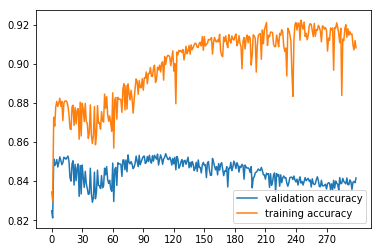

In [15]:
# (b) result plot
plt.plot(val_acc_list)
plt.plot(train_acc_list)
plt.legend(['validation accuracy', 'training accuracy'], loc='lower right')
plt.xticks(np.arange(0, epoch, step=30))
plt.show()